In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
FIG_PREFIX = 'webpage'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [3]:
root_dir = '../result/webpages_result'
root_free_dir = '../result/webpages_free_result'
root_lpms_dir = '../result/webpages_lpms_result'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [4]:
def build_stats_filename(row, previous_version, reduced):
    name = row['name']
    if 'parallel' in name:
    # if '-' in name:
        name = name.split('-')[0]
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if not previous_version:
        if reduced is not None:
            fields.insert(-1, str(reduced))
        elif 'BEST' in name:
            fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{row['num_threads']}"
        space_file += '_determ' if 'DETER' in name else '_random'
        # max_num = -1
    else:
        space_file += f"{name.lower()}_t{row['num_threads']}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        space_file += f"_c{row['selectivity']}"
        if 'FREE' in name:
            space_file += f"_n{row['gram_size']}"
    if 'key_upper_bound' in row:
            space_file += f"_{row['key_upper_bound']}"
            fields.insert(-1, str(int(row['key_upper_bound'])))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [5]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        # print(f'Error reading file {fullname}')
        pass
    return -1

In [6]:
def get_stats_df(row, previous_version=False, reduced=None, root_dir=root_dir):
    fname, space_f = build_stats_filename(row, previous_version, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [7]:
def add_num_after_filter(df, previous_version=False, reduced_list=None, root_dir=root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, previous_version, reduced=reduced, root_dir=root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [8]:
def build_result_df(root_dir, previous_version=False, reduced=None):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    summary_df = add_num_after_filter(summary_df, previous_version=previous_version, reduced_list=reduced, root_dir=root_dir)
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    return res_df

In [9]:
res_df1 = build_result_df(root_dir, True)
res_df1 = res_df1[(res_df1['num_keys'] > 0) & (res_df1['index_size'] < 18446744072060)]
res_df1.describe()

,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,17.0,17.000000,17.000000,1.700000e+01,17.000000,17.000000,17.000000,1.700000e+01,17.000000,17.000000,17.000000,17.000000,1.700000e+01,17.000000,17.000000,1.700000e+01
mean,16.0,1.647059,0.299412,3.830228e+05,3555.180824,2108.102596,5663.282941,7.928463e+08,0.041913,353.789106,353.831019,6017.113960,5.303708e+06,530370.847059,858336.117647,1.764651e+08
std,0.0,2.289683,0.263070,7.575767e+05,3877.791011,2640.070676,3492.716182,7.857383e+08,0.080035,78.979777,78.918893,3482.412102,1.716330e+06,171632.996273,5258.263578,3.991154e+07
min,16.0,-1.000000,0.050000,3.000000e+00,172.459000,0.000080,1101.700000,1.134800e+05,0.002013,238.613448,238.761733,1495.128663,2.825079e+06,282507.900000,854392.000000,1.489814e+08
25%,16.0,-1.000000,0.100000,3.000000e+00,173.420000,0.000188,1196.530000,2.972720e+05,0.002089,240.281663,240.331130,1570.389030,2.848943e+06,284894.300000,854392.000000,1.502160e+08
50%,16.0,2.000000,0.150000,2.318200e+04,1665.950000,949.548000,7749.290000,5.248684e+08,0.002680,393.453126,393.455774,7989.113790,6.273158e+06,627315.800000,854718.000000,1.513687e+08
75%,16.0,4.000000,0.500000,3.125550e+05,8555.040000,4923.430000,8560.830000,1.538097e+09,0.029915,421.278897,421.280986,8976.602202,6.273255e+06,627325.500000,865241.000000,2.158996e+08
max,16.0,6.000000,0.700000,2.566911e+06,8635.770000,6839.980000,8635.770000,2.007392e+09,0.266086,424.131137,424.133209,9057.050986,6.966370e+06,696637.000000,865241.000000,2.598855e+08


In [10]:
res_lpms_df = build_result_df(root_lpms_dir)
res_lpms_df.describe()

,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


In [11]:
res_free_df = build_result_df(root_free_dir)
res_free_df.describe()

,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,103.0,103.000000,103.000000,103.000000,103.000000,103.0,103.000000,103.000000,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.000000,1.030000e+02,102.0,103.000000,1.030000e+02
mean,16.0,5.242718,0.243010,6.116505,6.116505,0.0,208.616786,607.861728,816.478408,1.792382e+06,0.002307,535.005746,535.008053,1351.486460,6.898735e+06,696637.0,846419.766990,1.463075e+08
std,0.0,2.911997,0.231313,2.092475,2.092475,0.0,1.437279,330.756118,330.797115,1.042087e+06,0.000183,1.425428,1.425426,331.278821,6.864168e+05,0.0,84217.866997,1.455800e+07
min,16.0,2.000000,0.020000,5.000000,5.000000,0.0,204.507000,218.205000,425.892000,9.238600e+04,0.002184,531.123874,531.126142,959.371614,0.000000e+00,696637.0,0.000000,-1.000000e+00
25%,16.0,2.000000,0.100000,5.000000,5.000000,0.0,207.701500,254.421500,463.688500,1.343034e+06,0.002252,534.157876,534.160179,998.546299,6.966370e+06,696637.0,854718.000000,1.476412e+08
50%,16.0,4.000000,0.150000,5.000000,5.000000,0.0,208.626000,525.428000,734.595000,1.343034e+06,0.002269,535.051345,535.053572,1268.164438,6.966370e+06,696637.0,854718.000000,1.477177e+08
75%,16.0,8.000000,0.500000,5.000000,5.000000,0.0,209.612000,918.201000,1126.975000,2.911026e+06,0.002319,536.162512,536.164770,1662.147554,6.966370e+06,696637.0,854718.000000,1.478409e+08
max,16.0,10.000000,0.700000,10.000000,10.000000,0.0,211.977000,1151.910000,1360.620000,3.895636e+06,0.004021,537.914552,537.916884,1897.610578,6.966370e+06,696637.0,854718.000000,1.481062e+08


In [12]:
res_df1.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'selection_time', 'build_time', 'overall_index_time', 'index_size',
       'compile_time', 'match_time', 'overall_match_time', 'overall_time',
       'num_after_filter', 'per_query_num_after_filter', 'match_count',
       'compute_size'],
      dtype='object')

In [13]:
res_df = pd.concat([res_df1, res_free_df], ignore_index=True)

In [14]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]

In [15]:
res_df['gram_size'] = pd.to_numeric(res_df['gram_size'])

In [16]:
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['name', 'gram_size'])

In [17]:
res_df[res_df.match_time == res_df.match_time.min()]

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
14,FREE-parallel,16,4,0.15,1352857,1561.89,5918.11,7480.0,524868392.0,0.148285,...,7718.761733,2825142,282514.2,854392,232546724,NaN,NaN,0.697576,0.302424,FREE


In [18]:
res_df[res_df.gram_size == res_df.gram_size.min()]

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
0,BEST,16,-1,0.10,3,8586.84,0.000080,8586.84,113480.0,0.002143,...,9008.472543,6273158,627315.8,865241,150192364,NaN,NaN,0.862073,0.137927,BEST
1,BEST,16,-1,0.12,3,8635.77,0.000129,8635.77,176328.0,0.002089,...,9057.050986,6273158,627315.8,865241,150342000,NaN,NaN,0.862073,0.137927,BEST
2,BEST,16,-1,0.15,3,8599.57,0.000183,8599.57,297272.0,0.002040,...,9020.666422,6273160,627316.0,865241,150216016,NaN,NaN,0.862073,0.137927,BEST
3,BEST,16,-1,0.20,3,8555.04,0.000188,8555.04,297272.0,0.002071,...,8976.602202,6273160,627316.0,865241,150202756,NaN,NaN,0.862073,0.137927,BEST
4,BEST,16,-1,0.50,3,8628.79,0.000179,8628.79,297272.0,0.002013,...,9050.582364,6273160,627316.0,865241,150463304,NaN,NaN,0.862073,0.137927,BEST
5,BEST,16,-1,0.70,4,8518.55,0.000368,8518.55,641848.0,0.002072,...,8942.683209,6273255,627325.5,865241,149533612,NaN,NaN,0.862075,0.137925,BEST


In [19]:
new_res_df[['name','gram_size','selectivity','num_keys','precision']]

,name,gram_size,selectivity,num_keys,precision
0,BEST,-1,0.10,3,0.137927
2,BEST,-1,0.15,3,0.137927
5,BEST,-1,0.70,4,0.137925
17,FREE-parallel,2,0.02,5,0.122692
18,FREE-parallel,2,0.02,10,0.122692
11,FREE-parallel,2,0.70,22478,0.163206
10,FREE-parallel,2,0.50,23076,0.163206
7,FREE-parallel,2,0.10,23182,0.122692
9,FREE-parallel,2,0.15,23269,0.122692
8,FREE-parallel,2,0.12,23340,0.122692


('BEST', -1)
('FREE-parallel', 2)
('FREE-parallel', 4)
('FREE-parallel', 6)


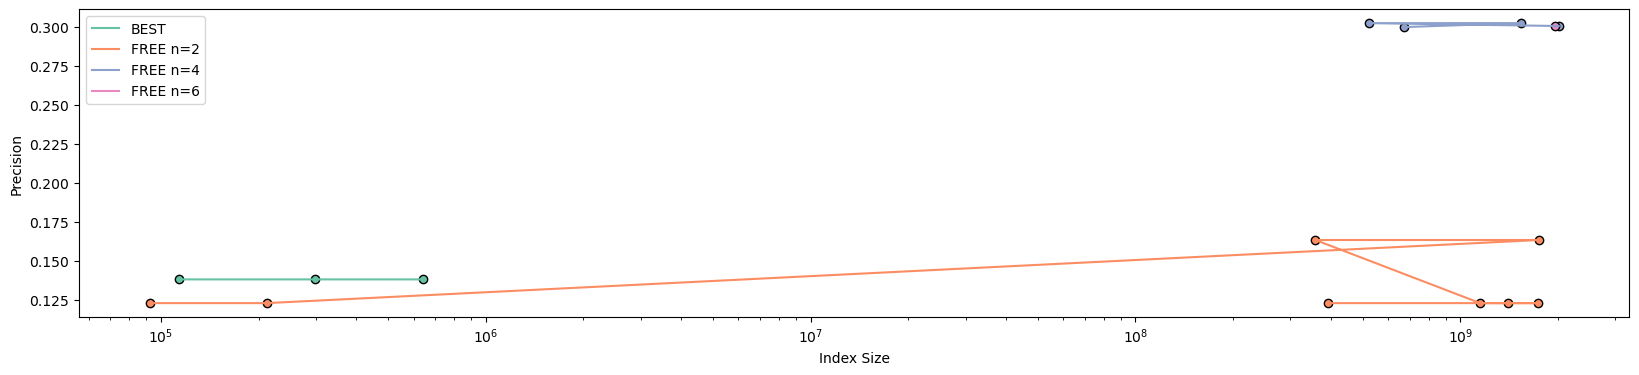

In [20]:
fig, ax = plt.subplots(figsize=(20,4))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['index_size']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Size')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrSize_prec.pdf', bbox_inches='tight')
plt.show()

('BEST', -1)
('FREE-parallel', 2)
('FREE-parallel', 4)
('FREE-parallel', 6)


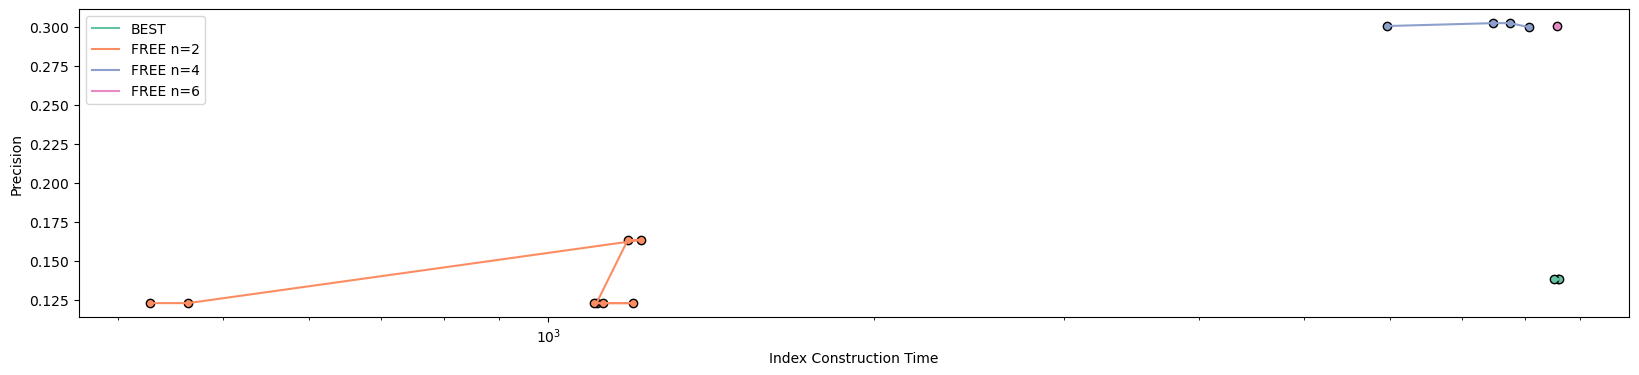

In [21]:
fig, ax = plt.subplots(figsize=(20,4))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['overall_index_time']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Construction Time')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrTime_prec.pdf', bbox_inches='tight')
plt.show()

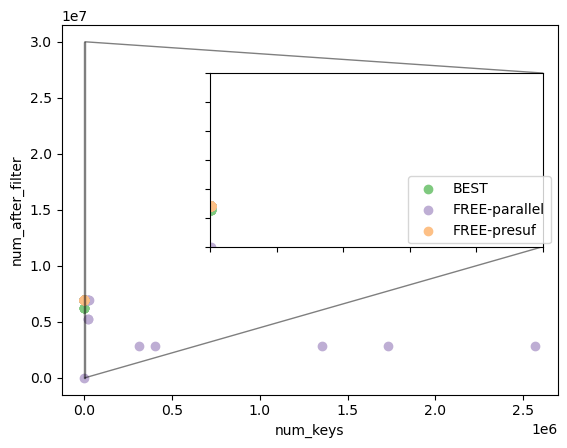

In [22]:
# explore the distribution of number of keys and number

groups = res_df.groupby('name')
colors = ['#7fc97f','#beaed4','#fdc086']
ax = plt.subplot()
for (name, group), color in zip(groups, colors):
    ax.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
ax.set_xlabel('num_keys')
ax.set_ylabel('num_after_filter')

# inset Axes....
x1, x2, y1, y2 = 0,5000, 0, 30000000  # subregion of the original image
axins = ax.inset_axes(
    [0.3, 0.4, 0.67, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for (name, group), color in zip(groups, colors):
    axins.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
# axins.scatter(res_df['num_keys'], res_df['num_after_filter'])
plt.legend()
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

In [23]:
# get their configurations
curr_examine = res_df[(res_df['num_keys'] <= x2) & (res_df['num_after_filter'] <= y2)]
trimed = curr_examine.loc[curr_examine.groupby('num_after_filter').gram_size.idxmin()]
trimed = trimed.sort_values(by='num_after_filter')

In [24]:
trimed

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
38,FREE-parallel,16,4,0.15,10,206.687,527.968000,734.655,2325452.0,0.002283,...,1270.743465,0,NaN,0,-1,10.0,0.0,NaN,NaN,FREE
0,BEST,16,-1,0.10,3,8586.840,0.000080,8586.840,113480.0,0.002143,...,9008.472543,6273158,627315.8,865241,150192364,NaN,NaN,0.862073,0.137927,BEST
2,BEST,16,-1,0.15,3,8599.570,0.000183,8599.570,297272.0,0.002040,...,9020.666422,6273160,627316.0,865241,150216016,NaN,NaN,0.862073,0.137927,BEST
5,BEST,16,-1,0.70,4,8518.550,0.000368,8518.550,641848.0,0.002072,...,8942.683209,6273255,627325.5,865241,149533612,NaN,NaN,0.862075,0.137925,BEST
17,FREE-parallel,16,2,0.02,5,208.618,219.057000,427.675,92386.0,0.002264,...,959.371614,6966370,696637.0,854718,147660224,5.0,0.0,0.877308,0.122692,FREE


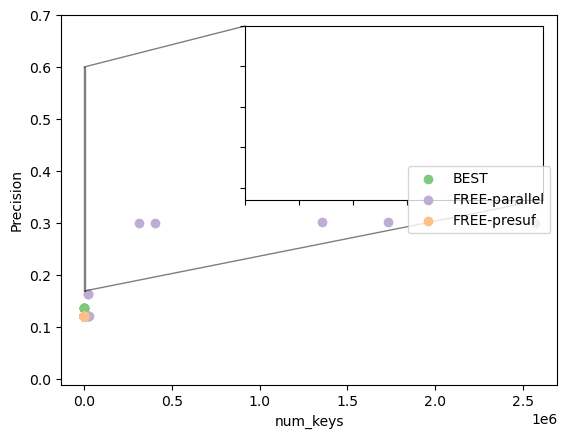

In [25]:
groups = res_df.groupby('name')
colors = ['#7fc97f','#beaed4','#fdc086']
ax = plt.subplot()
ax.set_ylim([-0.01, 0.7])
for (name, group), color in zip(groups, colors):
    ax.scatter(group['num_keys'], group['precision'], c=color, label=name)
ax.set_xlabel('num_keys')
ax.set_ylabel('Precision')

# print( res_df['match_count'])
# print(res_df['num_after_filter'])
# print(res_df['prop_error'])
# print((239136631-913841)/239136631)

# inset Axes....
x1, x2, y1, y2 = 0,5500, 0.17, 0.6  # subregion of the original image
axins = ax.inset_axes(
    [0.37, 0.5, 0.6, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for (name, group), color in zip(groups, colors):
    axins.scatter(group['num_keys'], group['precision'], c=color, label=name)
# axins.scatter(res_df['num_keys'], res_df['num_after_filter'])
plt.legend(loc='center right')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

In [26]:
# get their configurations
curr_examine = res_df[(res_df['num_keys'] <= x2) & (res_df['precision']>= y1)]
trimed = curr_examine.loc[curr_examine.groupby('num_after_filter').gram_size.idxmin()]
sorted_df = trimed.sort_values(by='precision')

In [27]:
trimed

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method


('BEST', -1)
('FREE-parallel', 2)
('FREE-parallel', 4)
('FREE-parallel', 6)


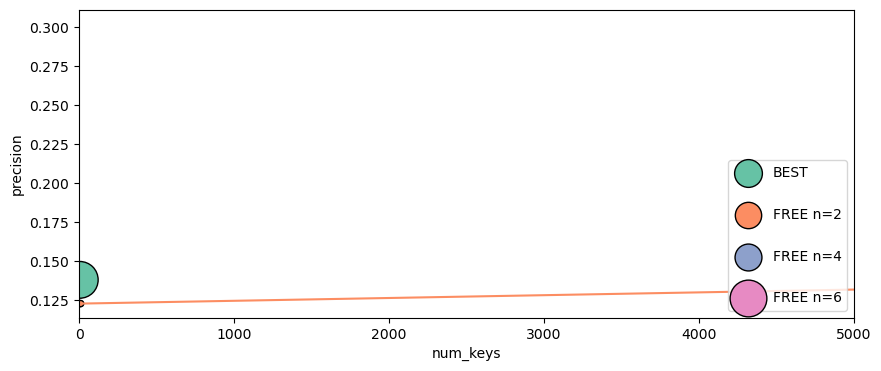

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')

new_groups = new_res_df.groupby(['name', 'gram_size'])
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color)
    ax.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--

ax.set_xlabel('num_keys')
ax.set_ylabel('precision')

ax.set_xlim([0, 5000])
plt.legend(loc="lower right", labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec.pdf', bbox_inches='tight')
plt.show()

In [29]:
new_res_df[new_res_df['num_keys'] < 5000].sort_values(by='num_after_filter', ascending=True)

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
38,FREE-parallel,16,4,0.15,10,206.687,527.968000,734.655,2325452.0,0.002283,...,1270.743465,0,NaN,0,-1,10.0,0.0,NaN,NaN,FREE
0,BEST,16,-1,0.10,3,8586.840,0.000080,8586.840,113480.0,0.002143,...,9008.472543,6273158,627315.8,865241,150192364,NaN,NaN,0.862073,0.137927,BEST
2,BEST,16,-1,0.15,3,8599.570,0.000183,8599.570,297272.0,0.002040,...,9020.666422,6273160,627316.0,865241,150216016,NaN,NaN,0.862073,0.137927,BEST
5,BEST,16,-1,0.70,4,8518.550,0.000368,8518.550,641848.0,0.002072,...,8942.683209,6273255,627325.5,865241,149533612,NaN,NaN,0.862075,0.137925,BEST
17,FREE-parallel,16,2,0.02,5,208.618,219.057000,427.675,92386.0,0.002264,...,959.371614,6966370,696637.0,854718,147660224,5.0,0.0,0.877308,0.122692,FREE
18,FREE-parallel,16,2,0.02,10,210.151,253.984000,464.135,211612.0,0.002374,...,998.686027,6966370,696637.0,854718,147645296,10.0,0.0,0.877308,0.122692,FREE


[      3       4       5      10   22478   23076   23182   23269   23340
   28637  312555  405302 1352857 1729761 2566911]


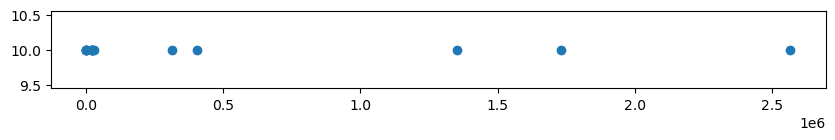

In [30]:
data = np.sort(new_res_df['num_keys'].unique())
print(data)
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))

In [31]:
# decide the split points
def pairwise_difference(lst):
    differences = []
    prec_diffs = []
    for i in range(len(lst) - 1):
        prec_diffs.append((lst[i + 1] - lst[i])/lst[i])
        differences.append(lst[i + 1] - lst[i])
    return differences, prec_diffs
diffs, prec_diffs = pairwise_difference(data)
idxs = np.argsort(diffs)
prec_idxs = np.argsort(prec_diffs)
print(idxs)

[ 0  1  2  7  6  5  4  8  3 10  9 12 13 11]


idx[1], between 4 and 5
idx[12], between 1352857 and 1729761
idx[10], between 312555 and 405302
idx[0], between 3 and 4
idx[13], between 1729761 and 2566911
idx[2], between 5 and 10
idx[11], between 405302 and 1352857
idx[9], between 28637 and 312555
idx[3], between 10 and 22478


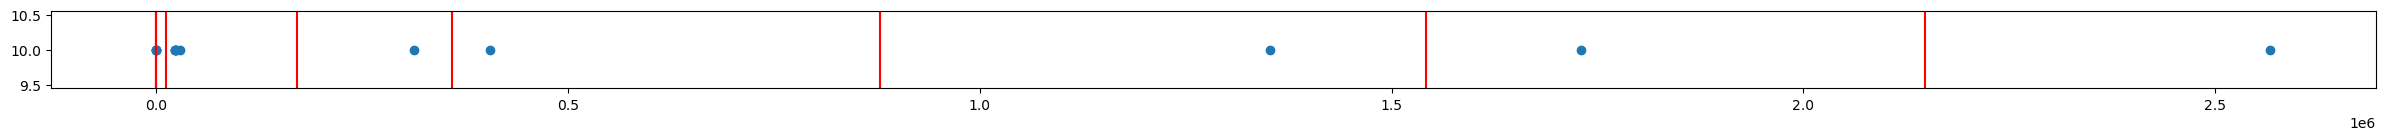

In [32]:
fig, ax = plt.subplots(figsize=(30, 1))
ax.scatter(data, [10] * len(data))
bins = [np.min(data)-1]
for idx in prec_idxs[-9:]:
    print(f'idx[{idx}], between {data[idx]} and {data[idx+1]}')
    curr_x = (data[idx] + data[idx + 1])/2
    bins.append(curr_x)
    ax.axvline(x=curr_x, color='red')
bins = np.sort(bins)
bins = np.append(bins, int(np.max(data)*1.01))

idx[1], between 4 and 5 at 4.5
idx[0], between 3 and 4 at 3.5
idx[2], between 5 and 10 at 7.5
idx[3], between 10 and 22478 at 11244.0


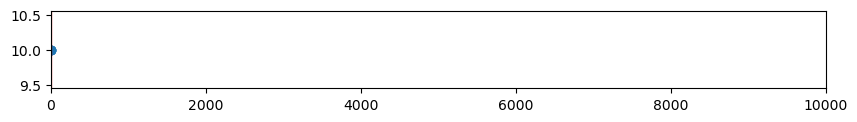

In [33]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))
ax.set_xlim([0, 10000])

for idx in prec_idxs[-9:]:
    if data[idx] < 10000:
        print(f'idx[{idx}], between {data[idx]} and {data[idx+1]} at {(data[idx] + data[idx + 1])/2}')
        curr_x = (data[idx] + data[idx + 1])/2
        ax.axvline(x=curr_x, color='red')

In [34]:
print(bins)

[2.000000e+00 3.500000e+00 4.500000e+00 7.500000e+00 1.124400e+04
 1.705960e+05 3.589285e+05 8.790795e+05 1.541309e+06 2.148336e+06
 2.592580e+06]


In [85]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None
# for up_lim in bins[2:]:
#     up_lim = np.ceil(up_lim)
#     print(up_lim)
#     curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
#     curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
#     # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
#     # print(curr_group)
#     curr_group = curr_group.sort_values(by='num_keys')
#     count = 0
#     curr_row_count = curr_group.shape[0]
#     curr_group['max_key'] = [up_lim]*curr_row_count
#     if summary_df is None:
#         summary_df = curr_group
#     else:
#         summary_df = pd.concat([summary_df, curr_group], ignore_index=True)

#     for _, row in curr_group.iterrows():
#         curr_str = ''
#         count += 1;
#         if count == 1:
#             curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(int(up_lim))+'}}'
#         curr_str += f'& {name_map[row["name"][:4]]} '

#         curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.1f}', curr_group)
#         curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
#         curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
#         curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
#         curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
#         print(curr_str, end='')
#         if count < curr_row_count:
#             print("\\\\ \cline{2-7}")
#         else:
#             print("\\\\ \hline")
#     # print(curr_group)

for up_lim in [5, 170000, 360000, 1500000]:
# for up_lim in bins[2:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    # curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group = curr_df.sort_values(by=['precision', 'index_size'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    # print(up_lim)
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    curr_group['max_key'] = [up_lim]*curr_row_count    
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+ f'{up_lim:.1e}' + '}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.0f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.1f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\ ")
        else:
            print("\\\\ \midrule")
            
    app = []
    for m in ['BEST', 'FREE', 'LPMS']:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)

    if summary_df is None:
        summary_df = curr_group
    else:
        summary_df = pd.concat([summary_df, curr_group], ignore_index=True)
summary_df['name'] = [ nm.split('-')[0] for nm in summary_df['name'].to_list()]

\multirow{2}{*}{\bf{5.0e+00}}& \best  & \cellcolor{green!50}{422} & 8587 & 150 & 0.1 & \cellcolor{yellow!50}{0.138} \\ 
& \free  & 532 & \cellcolor{green!50}{428} & \cellcolor{green!50}{148} & \cellcolor{green!50}{0.1} & 0.123 \\ \midrule
\multirow{2}{*}{\bf{1.7e+05}}& \best  & 422 & 8587 & \cellcolor{green!50}{150} & \cellcolor{green!50}{0.1} & 0.138 \\ 
& \free  & \cellcolor{green!50}{353} & \cellcolor{green!50}{1184} & 159 & 357.9 & \cellcolor{yellow!50}{0.163} \\ \midrule
\multirow{2}{*}{\bf{3.6e+05}}& \best  & 422 & 8587 & \cellcolor{green!50}{150} & \cellcolor{green!50}{0.1} & 0.138 \\ 
& \free  & \cellcolor{green!50}{240} & \cellcolor{green!50}{5965} & 240 & 2007.4 & \cellcolor{yellow!50}{0.301} \\ \midrule
\multirow{2}{*}{\bf{1.5e+06}}& \best  & 422 & 8587 & \cellcolor{green!50}{150} & \cellcolor{green!50}{0.1} & 0.138 \\ 
& \free  & \cellcolor{green!50}{239} & \cellcolor{green!50}{7480} & 233 & 524.9 & \cellcolor{yellow!50}{0.302} \\ \midrule


In [86]:
summary_df

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,max_key
0,BEST,16.0,-1.0,0.10,3.0,8586.840,0.00008,8586.840,1.134800e+05,0.002143,...,9008.472543,6273158.0,627315.8,865241.0,150192364,5.0,NaN,0.862073,0.137927,5.0
1,FREE,16.0,2.0,0.02,5.0,208.618,219.05700,427.675,9.238600e+04,0.002264,...,959.371614,6966370.0,696637.0,854718.0,147660224,5.0,0.0,0.877308,0.122692,5.0
2,LPMS,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000000e+00,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.000000,NaN
3,BEST,16.0,-1.0,0.10,3.0,8586.840,0.00008,8586.840,1.134800e+05,0.002143,...,9008.472543,6273158.0,627315.8,865241.0,150192364,170000.0,NaN,0.862073,0.137927,170000.0
4,FREE,16.0,2.0,0.50,23076.0,172.459,1011.58000,1184.040,3.579417e+08,0.002779,...,1537.002331,5237063.0,523706.3,854718.0,159074964,170000.0,0.0,0.836794,0.163206,170000.0
5,LPMS,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000000e+00,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.000000,NaN
6,BEST,16.0,-1.0,0.10,3.0,8586.840,0.00008,8586.840,1.134800e+05,0.002143,...,9008.472543,6273158.0,627315.8,865241.0,150192364,360000.0,NaN,0.862073,0.137927,360000.0
7,FREE,16.0,4.0,0.70,312555.0,1041.270,4923.43000,5964.690,2.007392e+09,0.029915,...,6204.533169,2842640.0,284264.0,854392.0,240414828,360000.0,0.0,0.699437,0.300563,360000.0
8,LPMS,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000000e+00,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.000000,NaN
9,BEST,16.0,-1.0,0.10,3.0,8586.840,0.00008,8586.840,1.134800e+05,0.002143,...,9008.472543,6273158.0,627315.8,865241.0,150192364,1500000.0,NaN,0.862073,0.137927,1500000.0


In [37]:
overall_df = None
for up_lim in bins[1:]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    print(up_lim)
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    app = []
    for m in ['BEST', 'FREE', 'LPMS']:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'num_keys': up_lim-1,
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)
    if overall_df is None:
        overall_df = curr_group
    else:
        overall_df = overall_df.append(curr_group, ignore_index=True)
overall_df['name'] = [ nm.split('-')[0] for nm in overall_df['name'].to_list()]

3.5
4.5
7.5
11244.0
170596.0
358928.5
879079.5
1541309.0
2148336.0
2592580.0


In [38]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[7, 11244, 170596, 358928, 879079, 1541309]
6      28637
7      23182
8      23340
9      23269
10     23076
       ...  
115        5
116        5
117        5
118        5
119        5
Name: num_keys, Length: 112, dtype: int64 6      0.122692
7      0.122692
8      0.122692
9      0.122692
10     0.163206
         ...   
115    0.122692
116    0.122692
117    0.122692
118    0.122692
119    0.122692
Name: precision, Length: 112, dtype: float64
6      28637
7      23182
8      23340
9      23269
10     23076
       ...  
115        5
116        5
117        5
118        5
119        5
Name: num_keys, Length: 112, dtype: int64 6      1101.70
7      1107.93
8      1196.53
9      1122.97
10     1184.04
        ...   
115    1354.88
116    1356.77
117    1357.35
118    1358.04
119    1357.29
Name: overall_index_time, Length: 112, dtype: float64
6      28637
7      23182
8      23340
9      23269
10     23076
       ...  
115        5
116        5
117        5
118        5
119        5
Nam

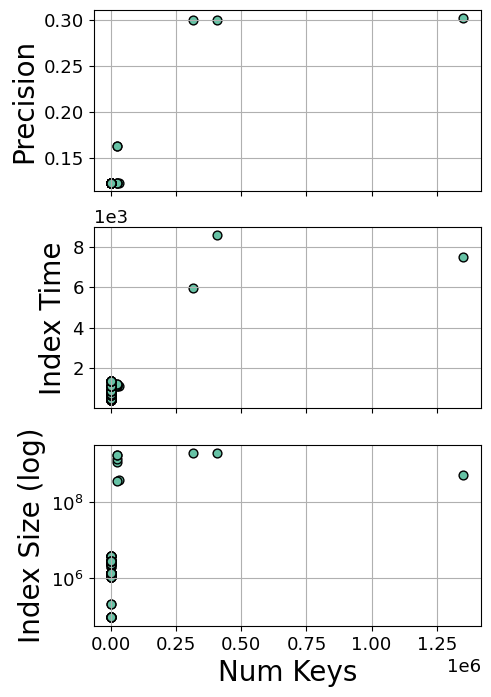

In [39]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
lims = [int(i) for i in bins[3:-2]]
print(lims)
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(5,8))
for col, ax in zip(['precision', 'overall_index_time', 'index_size'], axes.flatten()): #, 'compute_size']:
    
    # for method, color in zip(['BEST', 'FREE', 'LPMS'], colors):
    for method, color in zip(['FREE'], colors):
        curr = overall_df.loc[(overall_df["name"] == method) & (overall_df["num_keys"] > bins[2])]#.sort_values('name')
        
        X = curr['key_upper_bound']

        curr_all_df = res_df[(res_df["method"] == method) & (res_df["num_keys"] <= lims[-1])]
        print(curr_all_df['num_keys'], curr_all_df[col])
        if col == 'index_size':
            ax.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color, s=40, edgecolor='black', label=method)
            ax.set_xlabel('Num Keys')
        else:
            ax.scatter(curr_all_df['num_keys'], curr_all_df[col], s=40, edgecolor='black', c=color)
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'index_size':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3]) 
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    

    # ax.set_xticks(ticks=lims)#, labels=[f'{int(v/1000)}k' for v in lims[1:]])
    
    # fig.text(0.5, 0.04, 'Key Upper Bound', ha='center', va='center')
    # if col == 'compute_size':
    #     plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    ax.grid()
plt.savefig(f'figs/{FIG_PREFIX}.pdf', bbox_inches='tight')
plt.savefig(f'figs/{FIG_PREFIX}.svg', bbox_inches='tight')
plt.show()

[ 0.69314718  1.25276297  1.5040774   2.01490302  9.32758993 12.04705347
 12.79087848 13.68663062 14.24814261 14.58020415 14.76816408]


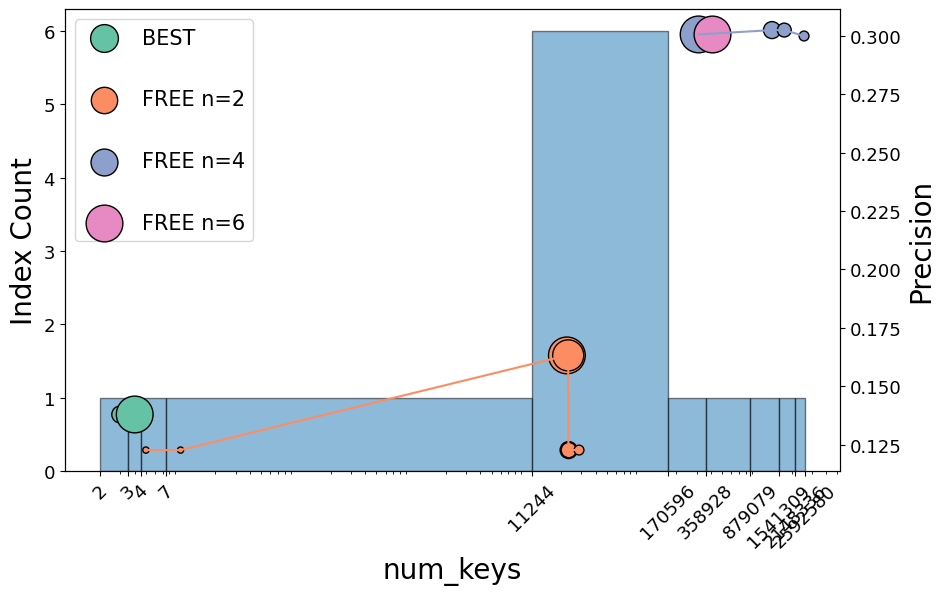

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black', alpha=0.5)
print(np.log(bins))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gca().set_xscale("log")
ax.set_xticks(bins)
ax.set_xticklabels([int(b) for b in bins], rotation=45)

ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    ax2.plot(X, Y, c=color)
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    sc = ax2.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    if name[0] == 'FREE-parallel':
        labs = (new_group['selectivity'].unique())
        labs = np.sort(labs)
        handles, labels = sc.legend_elements(prop="sizes", alpha=0.4,num=4)     
        # labels = new_group['selectivity'].unique()    
        # legend = ax.legend(handles, [" " , "Selectivity\nThreshold"," " ,  " "], title="Size")
        # ax.legend(*sc.legend_elements("sizes", num=4, alpha=0.5), loc='center right')

    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('Precision')
ax.set_ylabel('Index Count')
ax.set_xlabel('num_keys')
plt.legend(labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec_hist.pdf', bbox_inches='tight')
plt.show()

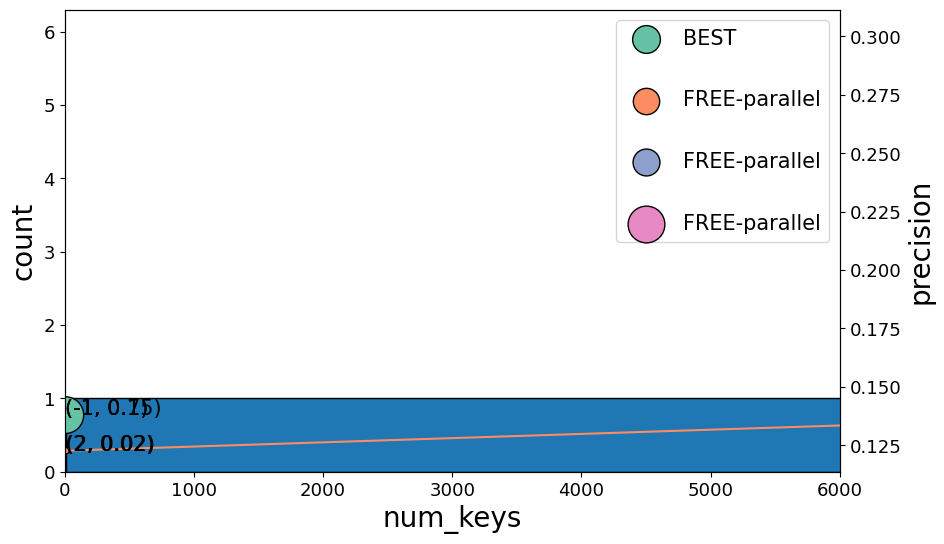

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black');
# plt.gca().set_xscale("log")
ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1
    if name == 'FREE-parallel':
        curr_new_group = new_group[new_group['gram_size'] == 4]
    else:
        curr_new_group = new_group
    X = curr_new_group['num_keys']
    Y = curr_new_group['precision']
    ax2.plot(X, Y, c=color)
    ax2.scatter(X, Y, marker='o', label=curr_new_group['name'].to_list()[0], c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*curr_new_group['selectivity'].to_numpy())
    for g, s, x, y in zip(curr_new_group['gram_size'], curr_new_group['selectivity'], X, Y):
        ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('precision')
ax.set_ylabel('count')
ax.set_xlabel('num_keys')
ax.set_xlim([0, 6000])
plt.legend(labelspacing=2)

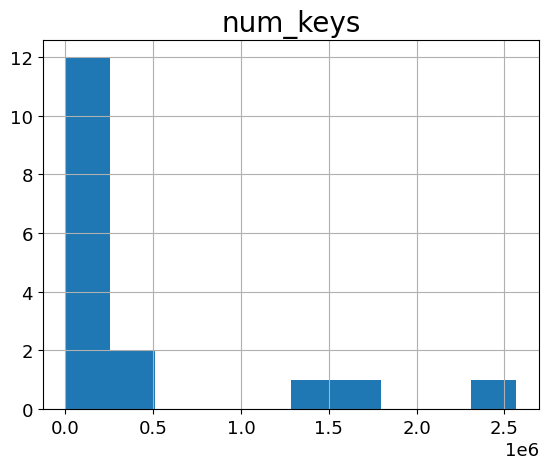

In [42]:
# bin them by number of 
BIN_NUM = 10
new_res_df.hist(column='num_keys', bins=BIN_NUM)
heights, bins = np.histogram(data, bins=BIN_NUM)

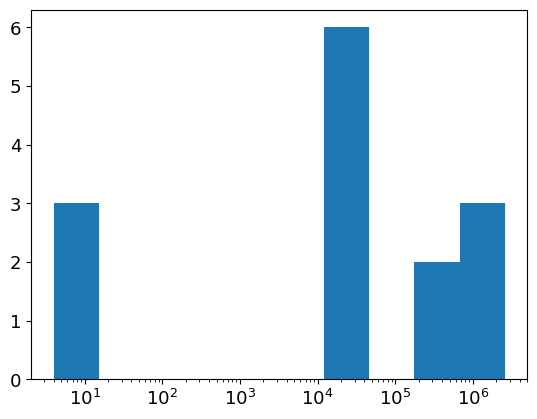

In [43]:
_, bins = np.histogram(np.log10(data + 1), bins=BIN_NUM)
plt.hist(data, bins=10**bins);
plt.gca().set_xscale("log")

In [44]:
edges = 10**bins
prev = 0
for b in edges:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True)[['name', 'num_keys', 'selection_time', 'num_after_filter']])
    prev = b
print([int(e) for e in edges])

   name  num_keys  selection_time  num_after_filter
0  BEST         3         8586.84           6273158
2  BEST         3         8599.57           6273160
             name  num_keys  selection_time  num_after_filter
38  FREE-parallel        10         206.687                 0
5            BEST         4        8518.550           6273255
17  FREE-parallel         5         208.618           6966370
18  FREE-parallel        10         210.151           6966370
Empty DataFrame
Columns: [name, num_keys, selection_time, num_after_filter]
Index: []
Empty DataFrame
Columns: [name, num_keys, selection_time, num_after_filter]
Index: []
Empty DataFrame
Columns: [name, num_keys, selection_time, num_after_filter]
Index: []
Empty DataFrame
Columns: [name, num_keys, selection_time, num_after_filter]
Index: []
Empty DataFrame
Columns: [name, num_keys, selection_time, num_after_filter]
Index: []
             name  num_keys  selection_time  num_after_filter
11  FREE-parallel     22478         173.23

<AxesSubplot:xlabel='num_keys', ylabel='Count'>

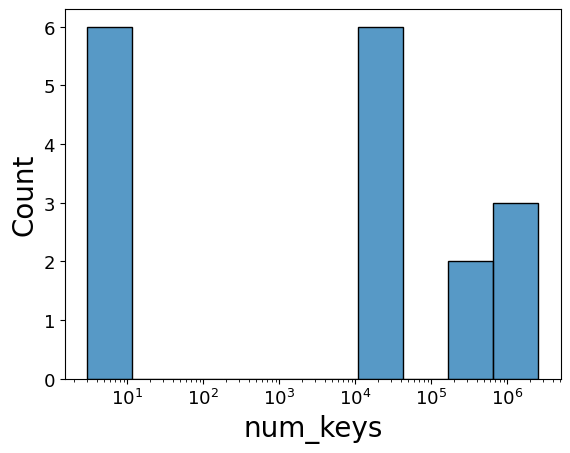

In [45]:
sns.histplot(new_res_df['num_keys'], bins=BIN_NUM, log_scale=True)

In [46]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

Empty DataFrame
Columns: [name, num_threads, gram_size, selectivity, num_keys, selection_time, build_time, overall_index_time, index_size, compile_time, match_time, overall_match_time, overall_time, num_after_filter, per_query_num_after_filter, match_count, compute_size, key_upper_bound, num_queries, prop_error, precision, method]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [name, num_threads, gram_size, selectivity, num_keys, selection_time, build_time, overall_index_time, index_size, compile_time, match_time, overall_match_time, overall_time, num_after_filter, per_query_num_after_filter, match_count, compute_size, key_upper_bound, num_queries, prop_error, precision, method]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [name, num_threads, gram_size, selectivity, num_keys, selection_time, build_time, overall_index_time, index_size, compile_time, match_time, overall_match_time, overall_time, num_after_filter, per_query_num_after_filter, match_count, compute_si

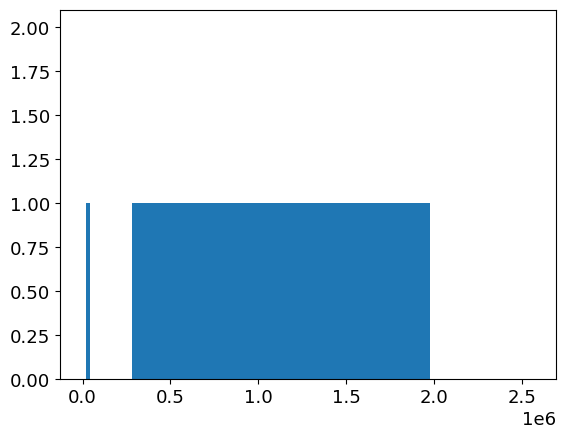

In [47]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x = new_res_df['num_keys'].to_numpy()
n, bins, patches = plt.hist(x, histedges_equalN(x, 20))

In [48]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

Empty DataFrame
Columns: [name, num_threads, gram_size, selectivity, num_keys, selection_time, build_time, overall_index_time, index_size, compile_time, match_time, overall_match_time, overall_time, num_after_filter, per_query_num_after_filter, match_count, compute_size, key_upper_bound, num_queries, prop_error, precision, method]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [name, num_threads, gram_size, selectivity, num_keys, selection_time, build_time, overall_index_time, index_size, compile_time, match_time, overall_match_time, overall_time, num_after_filter, per_query_num_after_filter, match_count, compute_size, key_upper_bound, num_queries, prop_error, precision, method]
Index: []

[0 rows x 22 columns]
   name  num_threads  gram_size  selectivity  num_keys  selection_time  \
0  BEST           16         -1         0.10         3         8586.84   
2  BEST           16         -1         0.15         3         8599.57   

   build_time  overall_index_time  index_size

In [49]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [50]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [51]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

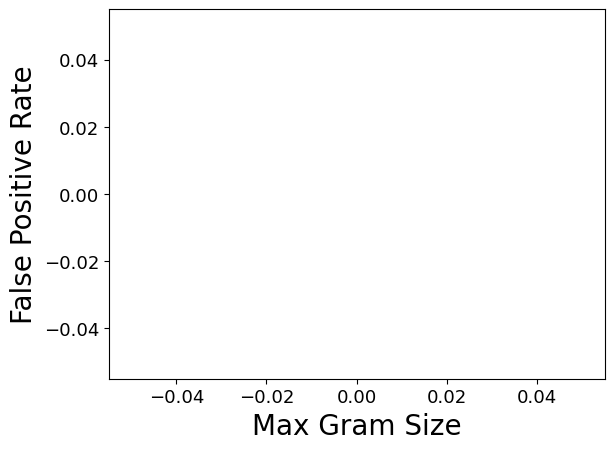

In [52]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

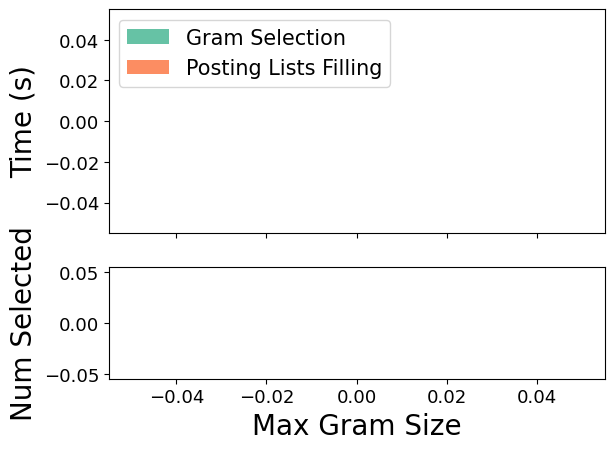

In [53]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

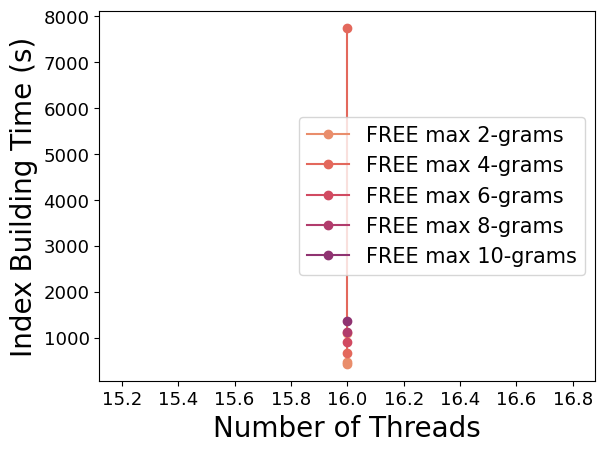

In [54]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

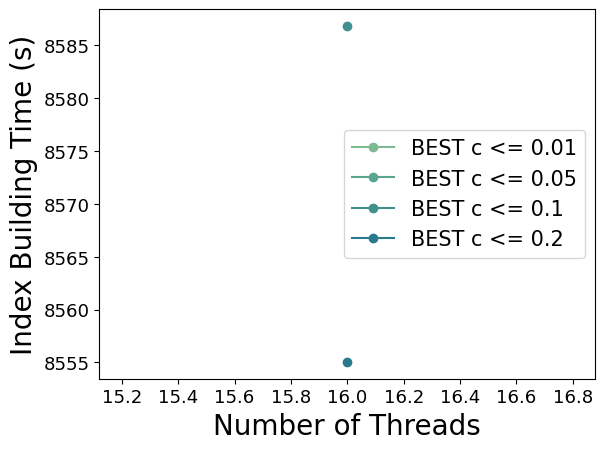

In [55]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

In [56]:
# root_dir = '../result/webpages_result'

In [57]:
# def build_stats_filename(row):
#     name = row['name']
#     # if 'parallel' in name:
#     if '-' in name:
#         name = name.split('-')[0]
#     fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
#     space_file = f"time_report_"
#     if 'LPMS' in name:
#         space_file += f"lpms_t{row['num_threads']}"
#         space_file += '_determ' if 'DETER' in name else '_random'
#     else:
#         space_file += f"{name.lower()}_t{row['num_threads']}_c{row['selectivity']}"
#         if 'FREE' in name:
#             space_file += f"_n{row['gram_size']}"
#     space_file += '.txt'
#     return '_'.join(fields), space_file   

In [58]:
# def get_compute_space(space_f):
#     with open(os.path.join(root_dir, space_f), 'r') as file:
#         for line in file:
#             if 'Maximum resident set size (kbytes)' in line:
#                 return int(line.strip().split(': ')[-1].strip())
#     return -1

In [59]:
# def get_stats_df(row):
#     fname, space_f = build_stats_filename(row)
#     return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f)

In [60]:
# summary_path = os.path.join(root_dir, 'summary.csv')
# summary_df = pd.read_csv(summary_path)

In [61]:
# summary_df.ffill(inplace=True)
# summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
# summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
# summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']

In [62]:
# # code for getting end-to-end trimmed mean
# res = summary_df.sort_values('overall_time')

In [63]:
# gb = res.groupby(by=id_cols)
# if gb.count()['selection_time'].min() > 2:
#     res = res.drop(gb.tail(1).index)
#     res = res.drop(gb.head(1).index)

In [64]:
# res_df = res.groupby(by=id_cols, as_index=False).mean(numeric_only=True).apply(lambda x: x)

In [65]:
# def add_num_after_filter(df):
#     new_cols = {
#         'num_after_filter': [],
#         'per_query_num_after_filter': [],
#         'match_count': [],
#         'compute_size': []
#     }
    
#     for _, row in df.iterrows():
#         detail_df, compute_size = get_stats_df(row)
#         new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
#         new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
#         new_cols['match_count'].append(detail_df['count'].sum())
#         new_cols['compute_size'].append(compute_size)
#         if row['name'] == 'BEST':
#             # print(detail_df['count'])
#             print(f"Average TP of regex: {detail_df['count'].mean()}")
#     return df.assign(**new_cols)

In [66]:
# res_df = add_num_after_filter(res_df)
# res_df.describe()

In [67]:
# res_df.columns

In [68]:
# res_df

In [69]:
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
